In [5]:
import os
import json
import tomli
import geopandas as gpd
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn import preprocessing

In [3]:
class VegIndexImages:
    def __init__(self, config_file="config.toml"):
        self.config_file = config_file
        
        try:
            with open(config_file, "rb") as f:
                self.config = tomli.load(f)
        except EnvironmentError as e:
            print(os.strerror(e.errno))
            print("Missing configiguration file.")
            print("Please create a config.toml file using config.toml.example as a template.")
        match self.config:
            case {
                "img_indices": {"img_folder": str(), 'veg_index': str()},
            }:
                pass
            case ValueError as e:
                print(f'Missing or incorrect value in config.toml')
                print(str(e))
        self.img_folder = self.config['img_indices']['img_folder']
        self.veg_index = self.config['img_indices']['veg_index']
        self.index_images_to_calc = []

    def get_images_for_index(self) -> dict :
        """Gets image paths for the vegetative index to calculate.

        Args:
            img_folder_path (str): Path to the folder with the downloaded Planet images
            veg_index (str): Which veg index to calculate (e.g., gci, ndvi)

        Returns:
            list: Image paths for the respective vegetative index to calculate.
        """
        images = glob.glob(f'{self.img_folder}/*.tif')
        index_folder = os.path.join(self.img_folder, self.veg_index)
        img_base_names = [os.path.basename(img) for img in images]
        #remove .tif from names
        img_base_names = [i[:len(i)-4] for i in img_base_names]
        if not os.path.exists(index_folder):
            os.makedirs(index_folder)
            self.index_images_to_calc = images
        else:
            existing_index_images = glob.glob(f'{index_folder}/*.tif')
            index_imgs = [i for i in img_base_names if i not in existing_index_images]
            for i in index_imgs:
                downloaded_index_img = glob.glob(f'{index_folder}/{i}_{self.veg_index}.tif')
                if not downloaded_index_img:
                    self.index_images_to_calc.append(f'{self.img_folder}/{i}.tif')
        return(self.index_images_to_calc)
    
    def calc_gci(self):
        for i in self.index_images_to_calc:
            img_base_name = os.path.basename(i)
            #remove .tif from names
            img_base_name = img_base_name[:len(img_base_name)-4]
            # open tif and read in bands
            with rio.open(i) as src:
                blue, green, red, nir = src.read()
            green = np.ma.masked_array(green, np.isnan(green))
            nir = np.ma.masked_array(nir, np.isnan(nir))
            gci = ((nir.astype(np.float32)) / ((green.astype(np.float32) + 0.00001))) - 1
            meta = src.meta
            meta.update(driver='GTiff')
            meta.update(dtype=rio.float32)
            meta.update(count=1)
            write_path = os.path.join(os.path.dirname(i), self.veg_index, f'{img_base_name}_gci.tif')
            # plt.imshow(src.read(1), cmap='greens')
            with rio.open(write_path, 'w', **meta) as dst:
                dst.write(gci.astype(rio.float32), indexes=1)

    def calc_ndvi(self):
        for i in self.index_images_to_calc:
            img_base_name = os.path.basename(i)
            #remove .tif from names
            img_base_name = img_base_name[:len(img_base_name)-4]
            # open tif and read in bands
            with rio.open(i) as src:
                blue, green, red, nir = src.read()
            red = np.ma.masked_array(red, np.isnan(red))
            nir = np.ma.masked_array(nir, np.isnan(nir))
            ndvi = (nir.astype(np.float32) - red.astype(np.float32))/(nir.astype(np.float32) + red.astype(np.float32))
            meta = src.meta
            meta.update(driver='GTiff')
            meta.update(dtype=rio.float32)
            meta.update(count=1)
            write_path = os.path.join(os.path.dirname(i), self.veg_index, f'{img_base_name}_ndvi.tif')
            # plt.imshow(src.read(1), cmap='greens')
            with rio.open(write_path, 'w', **meta) as dst:
                dst.write(ndvi.astype(rio.float32), indexes=1)

In [6]:
veg_images = VegIndexImages()

In [7]:
veg_images.get_images_for_index()


['data/imagery/Sievers/2018-07-01_2018-07-31/20180702_161312_100d.tif',
 'data/imagery/Sievers/2018-07-01_2018-07-31/20180708_161355_0f36.tif',
 'data/imagery/Sievers/2018-07-01_2018-07-31/20180724_161119_0f2b.tif',
 'data/imagery/Sievers/2018-07-01_2018-07-31/20180725_162228_101b.tif',
 'data/imagery/Sievers/2018-07-01_2018-07-31/20180726_162157_1035.tif']

In [8]:
veg_images.index_images_to_calc

['data/imagery/Sievers/2018-07-01_2018-07-31/20180702_161312_100d.tif',
 'data/imagery/Sievers/2018-07-01_2018-07-31/20180708_161355_0f36.tif',
 'data/imagery/Sievers/2018-07-01_2018-07-31/20180724_161119_0f2b.tif',
 'data/imagery/Sievers/2018-07-01_2018-07-31/20180725_162228_101b.tif',
 'data/imagery/Sievers/2018-07-01_2018-07-31/20180726_162157_1035.tif']

In [9]:
# veg_images.calc_gci()
# veg_images.calc_ndvi()

In [29]:
with rio.open('data/imagery/Sievers/2018-07-01_2018-07-31/20180702_161312_100d.tif') as src:
        blue, green, red, nir = src.read()

In [30]:
blue[blue >= 900] = -9999
green[green >= 900] = -9999
red[red >= 900] = -9999

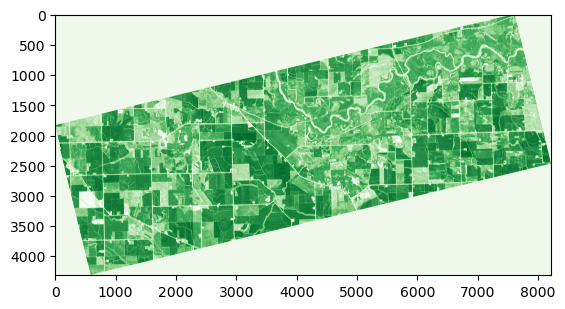

In [31]:
gci = ((nir.astype(np.float32) + 0.00001) / (green.astype(np.float32) + 0.00001)) - 1
meta = src.meta
meta.update(driver='GTiff')
meta.update(dtype=rio.float32)
meta.update(count=1)
plt.imshow(gci, cmap='Greens')


In [18]:
calc_gci('data/imagery/Sievers/2018-07-01_2018-07-31/20180702_161312_100d.tif')

RasterioIOError: Dataset is closed: data/imagery/Sievers/2018-07-01_2018-07-31/20180702_161312_100d.tif

In [ ]:
x_array = np.array([2,3,5,6,7,4,8,7,6])
normalized_arr = preprocessing.normalize([x_array])
print(normalized_arr)

In [ ]:
def normalize_gci():
    pass

In [ ]:
def create_gci_tif(folder_path):
    # green chlorophyll index
    # nir / green - 1
    images = glob.glob(f'{folder_path}/*.tif')
    #check to see if out tif already exists
    img_base_names = [os.path.basename(img) for img in images]
    img_base_names = [i[:len(i)-4] for i in img_base_names]
    for image in images:
        rio.open("path/to/image")
    with rio.open(image) as src:
        blue, green, red, nir = src.read()
    gci = (nir.astype(np.float32) / green.astype(np.float32)) - 1
    meta = nir.meta
    meta.update(driver='GTiff')
    meta.update(dtype=rio.float32)
    meta.update(count=1)
    with rio.open(out_path, 'w', **meta) as dst:
        dst.write(gci.astype(rio.float32))

In [ ]:
def calc_ndvi():
    pass